# Advanced Machine Learning
## Mini-project on Tagging Music Sequences
Authors: Ada Gige (adgi@itu.dk) and Ida Zachariassen (idza@itu.dk)

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Attention
from keras import backend as K

In [2]:
import tensorflow as tf

## Loading

### Audio files

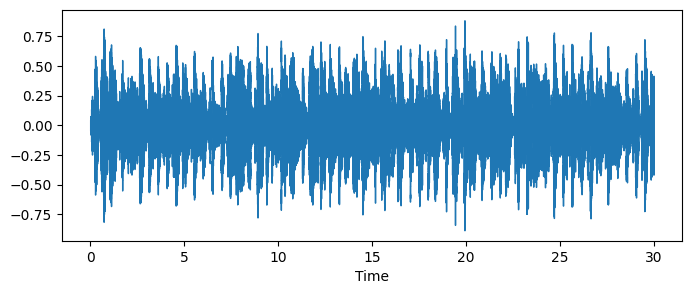

In [3]:
# time series
audio_ex = "../GTZAN/genres_original/blues/blues.00000.wav"
data, sr = librosa.load(audio_ex) # audio decoded as time series, sr = sampling rate (no. samples per second)

# waveplot
# https://librosa.org/doc/0.8.1/generated/librosa.display.waveplot.html



0 blues
FIRSY 0 0
1 classical
FIRSY 0 1
2 country
FIRSY 0 2
3 disco
FIRSY 0 3
4 hiphop
FIRSY 0 4


IndexError: index 5 is out of bounds for axis 0 with size 5

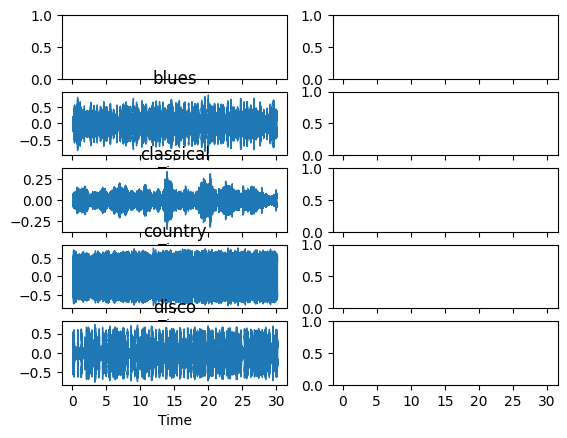

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

<Figure size 800x300 with 0 Axes>

In [28]:
# plot wave for each genre
fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True)

col_count = 0
row_count = 0
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
for i, genre in enumerate(genres):
    print(i, genre)
    audio_path = f"../GTZAN/genres_original/{genre}/{genre}.00000.wav"
    data, sr = librosa.load(audio_path)

    plt.figure(figsize=(8, 3))
    if col_count < 5:
        col_placement = 0
        row_placement = row_count
        print("FIRSY", col_placement, row_placement)
    else:
        col_placement = 1
        row_count = 0
        print("SECOND", col_placement, row_placement)
    col_count += 1
    row_count += 1

    
    librosa.display.waveshow(data, sr=sr, ax=ax[row_count, col_placement])
    ax[row_count, col_placement].set_title(f'{genre}')



In [ ]:
# plot average wave for each genre

### Features

In [7]:
df30 = pd.read_csv('../GTZAN/features_30_sec.csv')
print("Shape of features per 30 seconds:", df30.shape)
df30.head()

Shape of features per 30 seconds: (1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [8]:
df30['label'].value_counts()#.reset_index()

label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64

In [9]:
df3 = pd.read_csv('../GTZAN/features_3_sec.csv')
print("Shape of features per 3 seconds:", df3.shape)
df3.head()

Shape of features per 3 seconds: (9990, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [10]:
df3['label'].value_counts()#.reset_index()

label
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: count, dtype: int64

Text(0, 0.5, 'BPM')

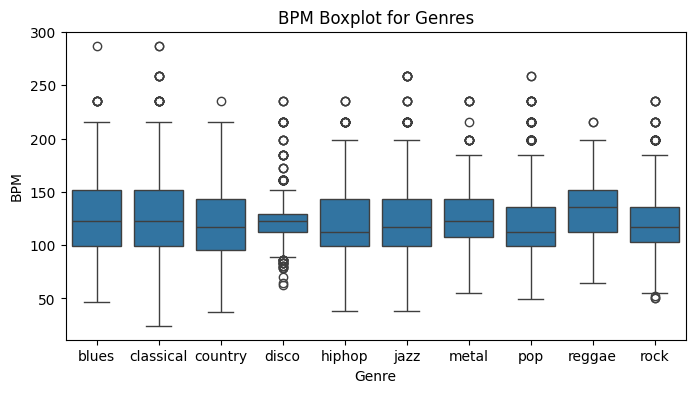

In [38]:
x = df3[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(8, 4));
sns.boxplot(x = "label", y = "tempo", data = x)

plt.title('BPM Boxplot for Genres')
plt.xlabel("Genre")
plt.ylabel("BPM")
#plt.savefig("BPM_genre_boxplot.png")

In [39]:
df3.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,66149.0,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


In [41]:
tempo_gb = df3.groupby('label').agg({'tempo': ['mean', 'min', 'max']}) 
tempo_gb

tempo                       
                 mean        min         max
label                                       
blues      126.690664  46.981534  287.109375
classical  125.888882  24.377211  287.109375
country    121.095174  37.449049  234.907670
disco      122.734182  63.024009  234.907670
hiphop     125.938210  37.999770  234.907670
jazz       122.972381  37.999770  258.398438
metal      124.987786  54.978391  234.907670
pop        123.140297  49.692007  258.398438
reggae     133.978200  64.599609  215.332031
rock       121.434986  50.666360  234.907670

In [17]:
feature_columns = ['chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label']

df3_gb = df3.groupby(by="label").mean()

TypeError: agg function failed [how->mean,dtype->object]

### Mel-Spectrograms

1. Split in train/test
2. Encode y-label (genre)
3. Scale features

In [17]:
labels = df3['label']
features = df3.drop(labels='label', axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
train_files = X_train['filename']
test_files = X_test['filename']
X_train = X_train.drop(labels='filename', axis=1)
X_test = X_test.drop(labels='filename', axis=1)

In [25]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.transform(y_test)

In [27]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [28]:
print(len(X_train), len(X_test))

7992 1998
